In [1]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import sys
import os
import access_era_5 as access_era_5
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm

/home/pbose/tcc/pesquisa/era5/access_era_5.py:9: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(caminho_completo, chunks={"valid_time": 100})


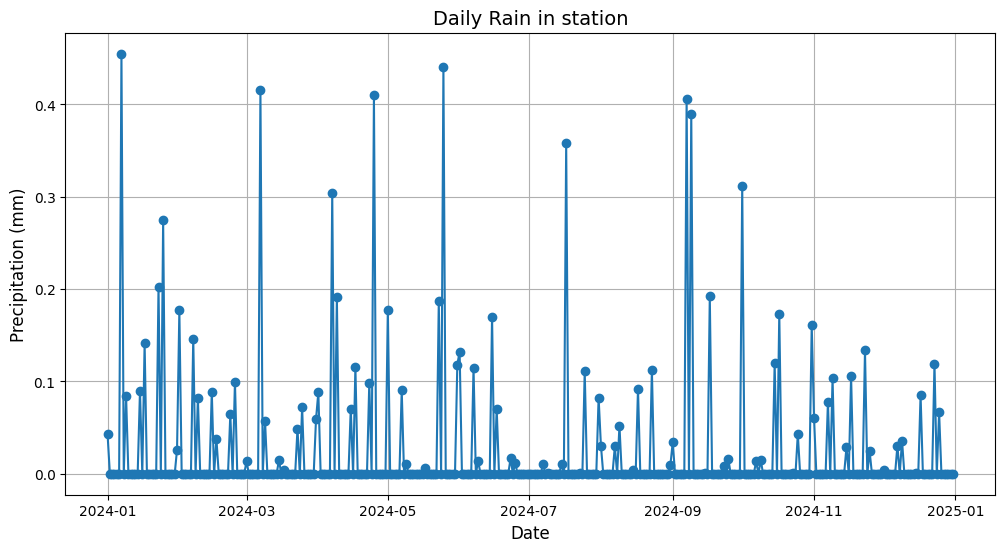

In [2]:
timeseries = access_era_5.recuperar_dados_era_5()
dias = timeseries['valid_time']

total_chuva = timeseries['tp']
dias = pd.to_datetime(dias)

# Faz o plot
plt.figure(figsize=(12,6))
plt.plot(dias, total_chuva, marker="o", linestyle="-")

plt.title("Daily Rain in station", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True)
plt.show()


In [3]:
lookback = 30
X, y = lstm.create_sequences_pytorch(total_chuva, lookback=lookback)
train_size = int(len(timeseries) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = dias[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([256, 30, 1]) torch.Size([256, 1])
torch.Size([80, 30, 1]) torch.Size([80, 1])


In [4]:
model = LstmModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=20)

In [5]:
n_epochs = 10

# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# --- Bloco de Avaliação Final (executado apenas uma vez) ---
print("\nTreinamento finalizado. Calculando erros...")
model.eval()  # modo avaliação
with torch.no_grad():
    # Previsões no conjunto de teste
    y_pred_test = model(X_test)
    
    # Se for LSTM com saída 2D (batch, 1), transforma para 1D
    y_pred_np = y_pred_test.detach().cpu().numpy().flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten()
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    
    # MSE
    mse = mean_squared_error(y_test_np, y_pred_np)
    
    # MAE
    mae = mean_absolute_error(y_test_np, y_pred_np)
    
print(f"Conjunto de Teste:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


# --- Novo Bloco para Imprimir Previsto vs. Esperado ---
print("\n--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---")
model.eval()
with torch.no_grad():
    # Pega as previsões finais do conjunto de teste
    y_pred_final = model(X_test)
    valores_previstos = y_pred_final.detach().cpu().numpy()
    valores_esperados = y_test.detach().cpu().numpy()

    # Itera sobre os 10 primeiros exemplos e imprime lado a lado
    for i in range(10):
        previsto = valores_previstos[i][0]
        esperado = valores_esperados[i][0]
        print(f"Exemplo {i+1}: Previsto = {previsto}, Esperado = {esperado}")


Treinamento finalizado. Calculando erros...
Conjunto de Teste:
RMSE: 0.0413
MSE: 0.0017
MAE: 0.0338

--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---
Exemplo 1: Previsto = 0.02785034477710724, Esperado = 0.0
Exemplo 2: Previsto = 0.027852479368448257, Esperado = 0.0
Exemplo 3: Previsto = 0.027854017913341522, Esperado = 0.11968612670898438
Exemplo 4: Previsto = 0.02783120796084404, Esperado = 0.0
Exemplo 5: Previsto = 0.027818404138088226, Esperado = 0.17309188842773438
Exemplo 6: Previsto = 0.0277845598757267, Esperado = 0.0
Exemplo 7: Previsto = 0.027772560715675354, Esperado = 0.0
Exemplo 8: Previsto = 0.02778163179755211, Esperado = 0.0
Exemplo 9: Previsto = 0.027799591422080994, Esperado = 0.0
Exemplo 10: Previsto = 0.02781767025589943, Esperado = 0.0


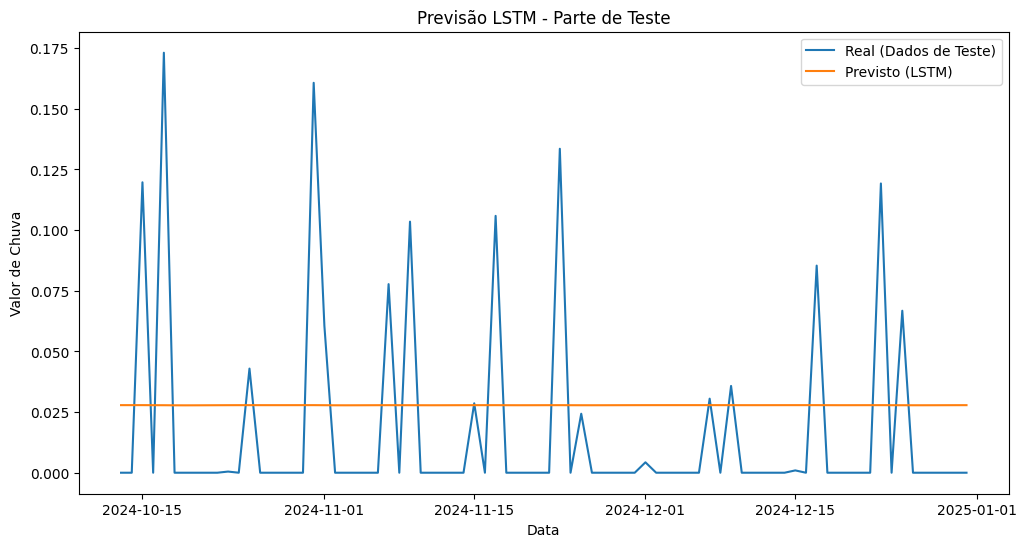

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(test_date, y_test_np, label="Real (Dados de Teste)")
plt.plot(test_date, y_pred_np, label="Previsto (LSTM)")
plt.title("Previsão LSTM - Parte de Teste")
plt.xlabel("Data")
plt.ylabel("Valor de Chuva")
plt.legend()
plt.show()